BUAI 435 Assignment 1 - Churn Prediction  
Name: Ruihuang Yang  
NetID: rxy216  
Date: 09/14/2025  

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import statsmodels.api as sm

# Set up beautiful plotting style
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

### Q1 - Steps 1 & 2: Preprocessing & Variable Setup

#### Load the CSV data

In [2]:
# Load the dataset
df = pd.read_csv('data/Telco-Customer-Churn.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


#### Preprocessing: TotalCharges and Churn conversion

In [3]:
# Coerce TotalCharges to numeric and impute missing values with mean
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
mean_total_charges = df['TotalCharges'].mean()
print(f"Missing values in TotalCharges before imputation: {df['TotalCharges'].isna().sum()}")
df['TotalCharges'] = df['TotalCharges'].fillna(mean_total_charges)
print(f"TotalCharges mean used for imputation: {mean_total_charges:.2f}")
print(f"Missing values in TotalCharges after imputation: {df['TotalCharges'].isna().sum()}")

# Convert Churn to 0/1 (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"Churn value counts:\n{df['Churn'].value_counts()}")

Missing values in TotalCharges before imputation: 11
TotalCharges mean used for imputation: 2283.30
Missing values in TotalCharges after imputation: 0
Churn value counts:
Churn
0    5174
1    1869
Name: count, dtype: int64


#### Create Manual Dummy Variables

In [4]:
# Manually create four dummies (do NOT one-hot encode these)
df['gender_Female'] = (df['gender'] == 'Female').astype(int)
df['PhoneService_Yes'] = (df['PhoneService'] == 'Yes').astype(int)
df['InternetService_Fiber optic'] = (df['InternetService'] == 'Fiber optic').astype(int)
df['Contract_Two year'] = (df['Contract'] == 'Two year').astype(int)

print("Manual dummy variables created:")
print(f"gender_Female: {df['gender_Female'].value_counts().to_dict()}")
print(f"PhoneService_Yes: {df['PhoneService_Yes'].value_counts().to_dict()}")
print(f"InternetService_Fiber optic: {df['InternetService_Fiber optic'].value_counts().to_dict()}")
print(f"Contract_Two year: {df['Contract_Two year'].value_counts().to_dict()}")

Manual dummy variables created:
gender_Female: {0: 3555, 1: 3488}
PhoneService_Yes: {1: 6361, 0: 682}
InternetService_Fiber optic: {0: 3947, 1: 3096}
Contract_Two year: {0: 5348, 1: 1695}


#### Data Overview - Info and Head

In [5]:
# Show df.info() and df.head() for sanity check
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customerID                   7043 non-null   object 
 1   gender                       7043 non-null   object 
 2   SeniorCitizen                7043 non-null   int64  
 3   Partner                      7043 non-null   object 
 4   Dependents                   7043 non-null   object 
 5   tenure                       7043 non-null   int64  
 6   PhoneService                 7043 non-null   object 
 7   MultipleLines                7043 non-null   object 
 8   InternetService              7043 non-null   object 
 9   OnlineSecurity               7043 non-null   object 
 10  OnlineBackup                 7043 non-null   object 
 11  DeviceProtection             7043 non-null   object 
 12  TechSupport                  7043 non-null   object 
 13  Stre

In [6]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Female,PhoneService_Yes,InternetService_Fiber optic,Contract_Two year
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,0,0,1,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,1,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,1,1,0


### Q2 - Step 3: EDA (Exploratory Data Analysis)

#### Setup: Create graphs folder for saving plots

In [7]:
# Create graphs folder if it doesn't exist
os.makedirs('graphs', exist_ok=True)
print("Graphs folder created/verified")

Graphs folder created/verified


#### Distribution Analysis for Numeric Variables

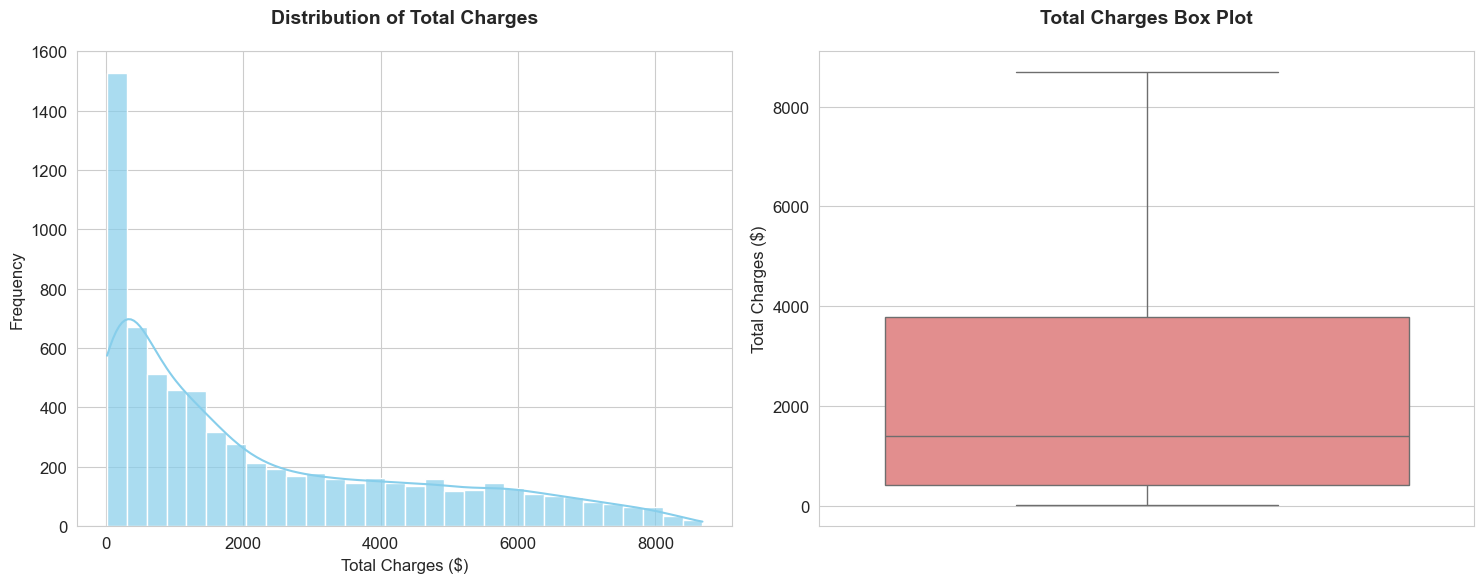

=== TOTAL CHARGES - BASIC STATISTICS ===
Mean: $2283.30
Median: $1400.55
Standard Deviation: $2265.00
Minimum: $18.80
Maximum: $8684.80
25th Percentile: $402.23
75th Percentile: $3786.60


In [8]:
# Analyze distribution of TotalCharges (a key numeric variable)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution plot with histogram and KDE
sns.histplot(data=df, x='TotalCharges', bins=30, kde=True, ax=ax1, color='skyblue', alpha=0.7)
ax1.set_title('Distribution of Total Charges', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Total Charges ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

# Box plot to show outliers and quartiles
sns.boxplot(data=df, y='TotalCharges', ax=ax2, color='lightcoral')
ax2.set_title('Total Charges Box Plot', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Total Charges ($)', fontsize=12)

plt.tight_layout()
plt.savefig('graphs/totalcharges_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Basic statistics for TotalCharges
print("=== TOTAL CHARGES - BASIC STATISTICS ===")
print(f"Mean: ${df['TotalCharges'].mean():.2f}")
print(f"Median: ${df['TotalCharges'].median():.2f}")
print(f"Standard Deviation: ${df['TotalCharges'].std():.2f}")
print(f"Minimum: ${df['TotalCharges'].min():.2f}")
print(f"Maximum: ${df['TotalCharges'].max():.2f}")
print(f"25th Percentile: ${df['TotalCharges'].quantile(0.25):.2f}")
print(f"75th Percentile: ${df['TotalCharges'].quantile(0.75):.2f}")

#### Monthly Charges Distribution

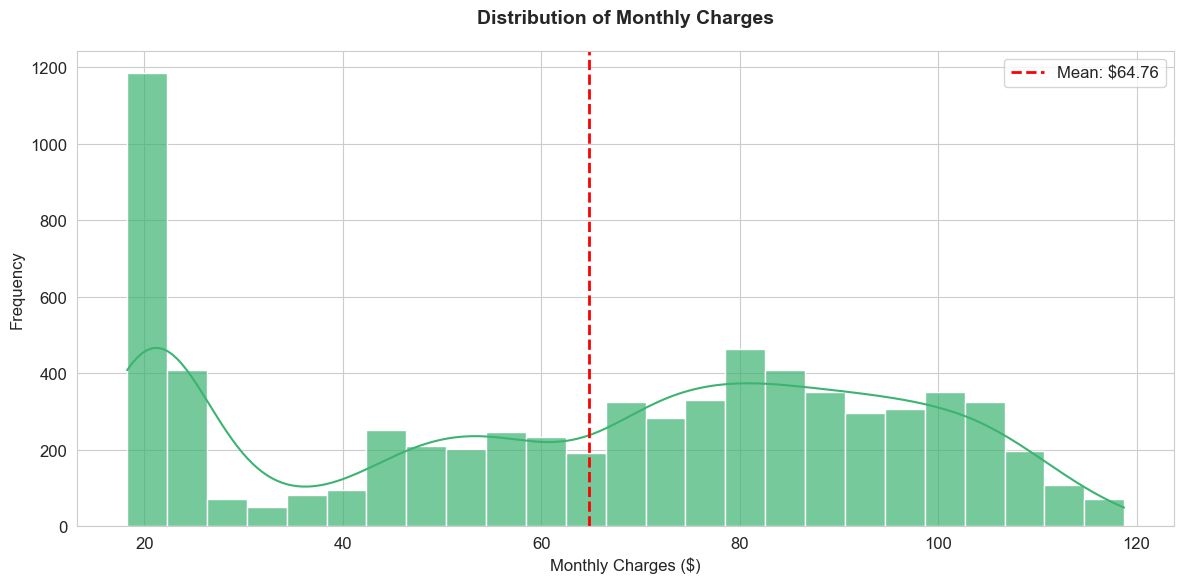

=== MONTHLY CHARGES - BASIC STATISTICS ===
Mean: $64.76
Median: $70.35
Standard Deviation: $30.09
Range: $18.25 - $118.75


In [9]:
# Also analyze MonthlyCharges distribution
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='MonthlyCharges', bins=25, kde=True, ax=ax, color='mediumseagreen', alpha=0.7)
ax.set_title('Distribution of Monthly Charges', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Monthly Charges ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add mean line
mean_monthly = df['MonthlyCharges'].mean()
ax.axvline(mean_monthly, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_monthly:.2f}')
ax.legend()

plt.tight_layout()
plt.savefig('graphs/monthlycharges_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== MONTHLY CHARGES - BASIC STATISTICS ===")
print(f"Mean: ${df['MonthlyCharges'].mean():.2f}")
print(f"Median: ${df['MonthlyCharges'].median():.2f}")
print(f"Standard Deviation: ${df['MonthlyCharges'].std():.2f}")
print(f"Range: ${df['MonthlyCharges'].min():.2f} - ${df['MonthlyCharges'].max():.2f}")

#### Churn Rate Analysis

=== OVERALL CHURN RATE ===
Overall Churn Rate: 26.5% (1,869 out of 7,043 customers)


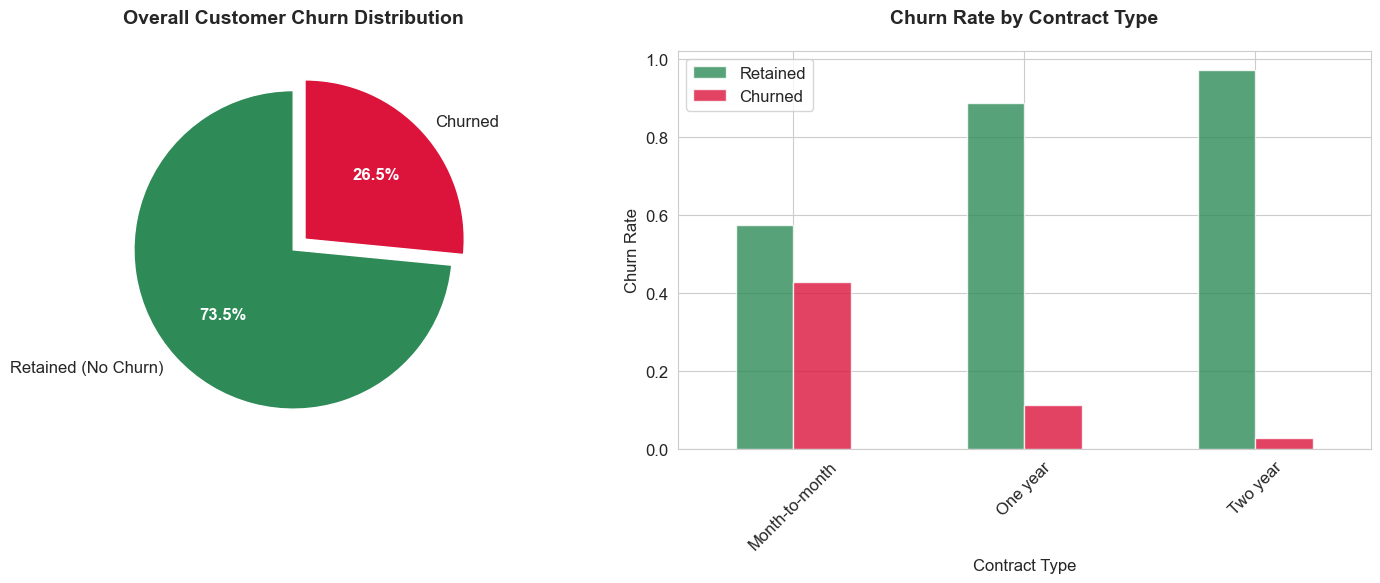

In [10]:
# Overall churn rate
overall_churn_rate = df['Churn'].mean()
print("=== OVERALL CHURN RATE ===")
print(f"Overall Churn Rate: {overall_churn_rate:.1%} ({df['Churn'].sum():,} out of {len(df):,} customers)")

# Create beautiful churn rate visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall churn pie chart
churn_counts = df['Churn'].value_counts()
labels = ['Retained (No Churn)', 'Churned']
colors = ['#2E8B57', '#DC143C']
wedges, texts, autotexts = ax1.pie(churn_counts.values, labels=labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90, explode=(0, 0.1))
ax1.set_title('Overall Customer Churn Distribution', fontsize=14, fontweight='bold', pad=20)

# Beautify the text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# Churn rate by Contract type
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index')
contract_churn.plot(kind='bar', ax=ax2, color=['#2E8B57', '#DC143C'], alpha=0.8)
ax2.set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Contract Type', fontsize=12)
ax2.set_ylabel('Churn Rate', fontsize=12)
ax2.legend(['Retained', 'Churned'], loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graphs/churn_analysis_overview.png', dpi=300, bbox_inches='tight')
plt.show()

#### Detailed Churn Analysis by Contract Type

=== CHURN RATE BY CONTRACT TYPE ===
Raw counts:
Churn              0     1   All
Contract                        
Month-to-month  2220  1655  3875
One year        1307   166  1473
Two year        1647    48  1695
All             5174  1869  7043

Percentages:
Churn              0     1
Contract                  
Month-to-month  57.3  42.7
One year        88.7  11.3
Two year        97.2   2.8


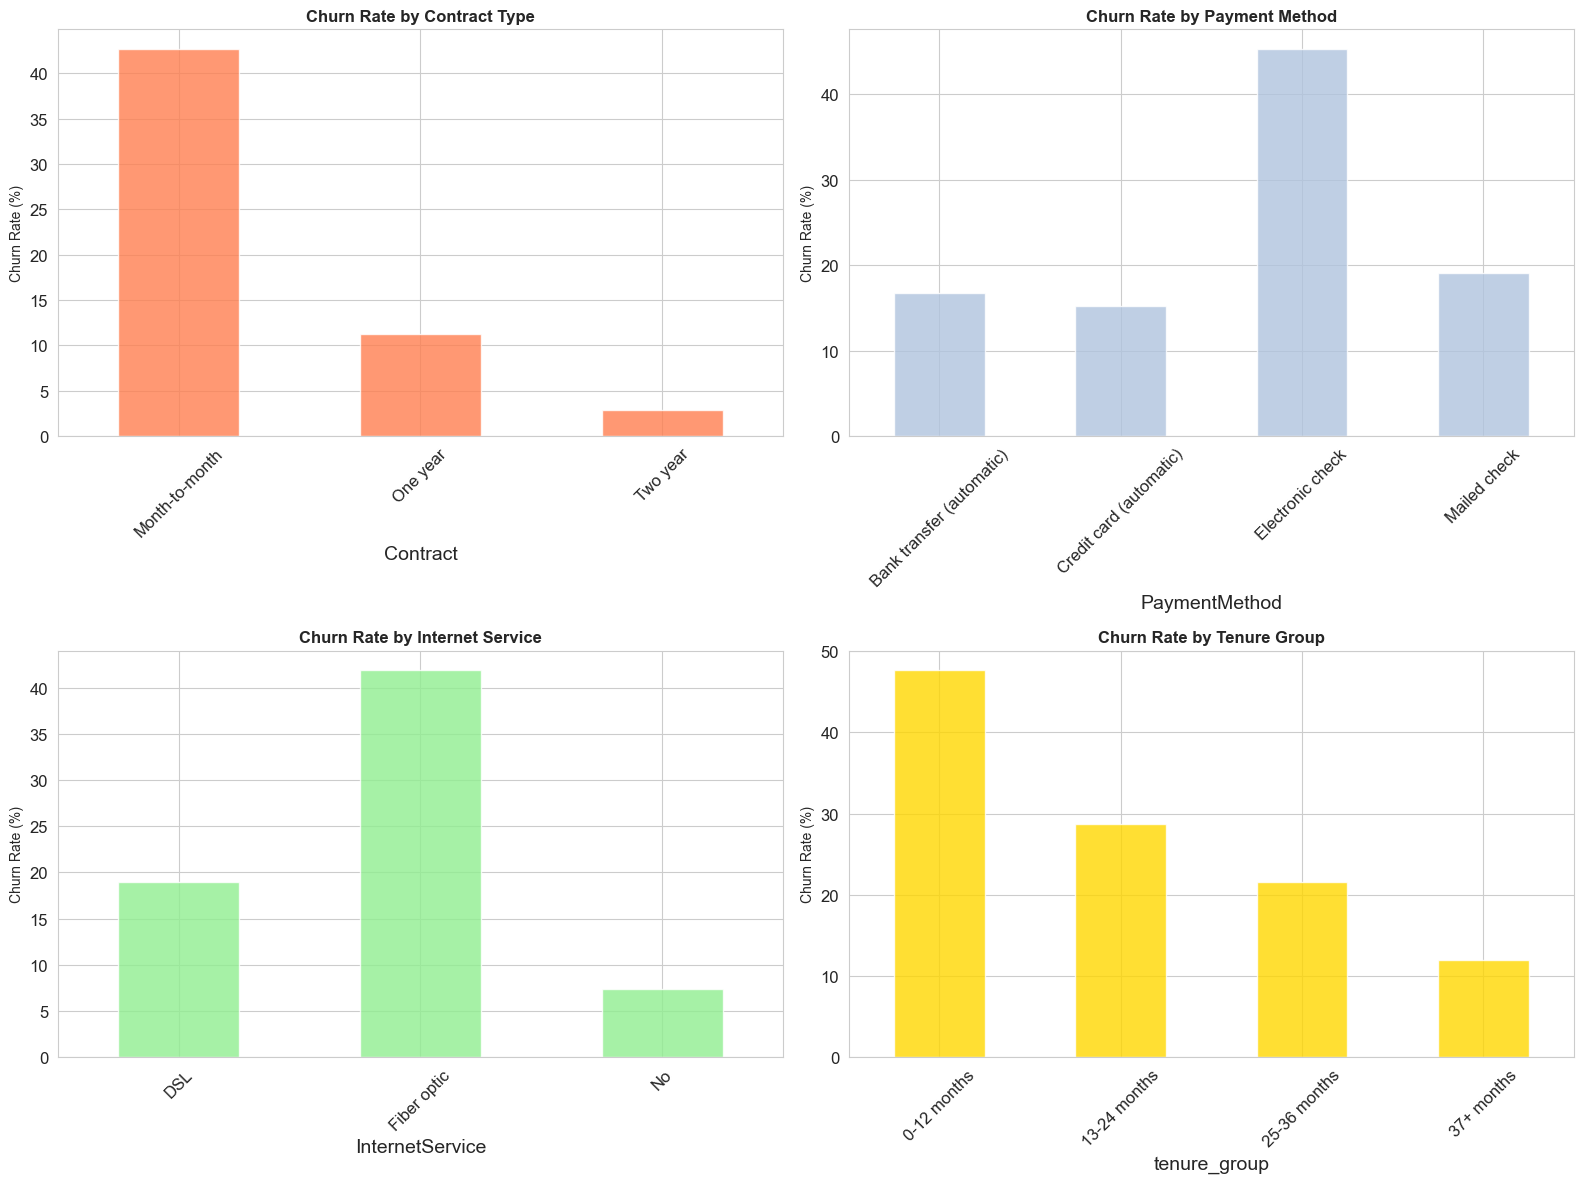

In [11]:
# Create crosstab for Contract vs Churn
contract_crosstab = pd.crosstab(df['Contract'], df['Churn'], margins=True)
contract_churn_pct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100

print("=== CHURN RATE BY CONTRACT TYPE ===")
print("Raw counts:")
print(contract_crosstab)
print("\nPercentages:")
print(contract_churn_pct.round(1))

# Beautiful bar chart for churn rates by different categories
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Churn by Contract Type
contract_churn_pct[1].plot(kind='bar', ax=ax1, color='coral', alpha=0.8)
ax1.set_title('Churn Rate by Contract Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Churn Rate (%)', fontsize=10)
ax1.tick_params(axis='x', rotation=45)

# 2. Churn by Payment Method
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index')[1] * 100
payment_churn.plot(kind='bar', ax=ax2, color='lightsteelblue', alpha=0.8)
ax2.set_title('Churn Rate by Payment Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Churn Rate (%)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)

# 3. Churn by Internet Service
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index')[1] * 100
internet_churn.plot(kind='bar', ax=ax3, color='lightgreen', alpha=0.8)
ax3.set_title('Churn Rate by Internet Service', fontsize=12, fontweight='bold')
ax3.set_ylabel('Churn Rate (%)', fontsize=10)
ax3.tick_params(axis='x', rotation=45)

# 4. Churn by Tenure groups
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 72], labels=['0-12 months', '13-24 months', '25-36 months', '37+ months'])
tenure_churn = pd.crosstab(df['tenure_group'], df['Churn'], normalize='index')[1] * 100
tenure_churn.plot(kind='bar', ax=ax4, color='gold', alpha=0.8)
ax4.set_title('Churn Rate by Tenure Group', fontsize=12, fontweight='bold')
ax4.set_ylabel('Churn Rate (%)', fontsize=10)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graphs/churn_by_categories.png', dpi=300, bbox_inches='tight')
plt.show()

#### EDA Insights and Observations

**Key Observations from EDA:**

• **Customer Revenue Distribution Insights**: Total charges exhibit a highly right-skewed distribution (mean $2,283 vs median $1,401), indicating that most customers generate lower lifetime revenue while a minority are high-value customers. Monthly charges are more balanced (mean $64.76 vs median $70.35) with substantial variation ($18-$119 range), suggesting diverse service tier adoption across the customer base.

• **Contract Commitment as Primary Churn Driver**: The data reveals a dramatic churn gradient by contract type - month-to-month customers have a 42.7% churn rate (15x higher risk), one-year contracts show 11.3% churn, while two-year contracts demonstrate exceptional retention at just 2.8% churn. This 40-point difference underscores contract commitment as the strongest predictor of customer retention.

• **Customer Lifecycle and Service Risk Factors**: Analysis reveals that newer customers (0-12 months tenure) face the highest churn risk, while fiber optic internet subscribers and electronic check payment users show elevated churn rates. The overall company churn rate of 26.5% (1,869 of 7,043 customers) suggests significant revenue at risk, particularly concentrated in the month-to-month segment which represents 55% of the customer base.